# Discrete DQN

This is the implementation of DQN for discrete action space using environment information inputs.

## Setup arguments

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

import time

import torch
import random

from torch_rl.jupyter_utils import (
    WidgetParser,
    plot_metrics_notebook
)

from torch_rl.utils import (
    seed_everything,
    handle_terminal_ob,
    mp4_to_gif,
    MetricStore,
    SPS
)


parser = WidgetParser()
parser.add_widget(widgets.IntText(
    description='seed',
    value=1,
    tooltip="seed of the experiment"
))

parser.add_widget(widgets.Checkbox(
    description="torch-deterministic",
    value=True,
    disabled=False,
    indent=False,
    tooltip="if toggled, `torch.backends.cudnn.deterministic=False`"
))

parser.add_widget(widgets.Checkbox(
    description="cuda",
    value=True,
    disabled=False,
    indent=False,
    tooltip="if toggled, cuda will be enabled by default"
))

parser.add_widget(widgets.Checkbox(
    description="capture-video",
    value=False,
    disabled=False,
    indent=False,
    tooltip="whether to capture videos of the agent performances (check out `videos` folder)"
))

parser.add_widget(widgets.Text(
    description="env-id",
    value="CartPole-v1",
    tooltip="the id of the environment"
))

parser.add_widget(widgets.IntText(
    description='total-timesteps',
    value=500000,
    tooltip="total timesteps of the experiments"
))

parser.add_widget(widgets.FloatText(
    description='learning-rate',
    value=2.5e-4,
    tooltip="the learning rate of the optimizer"
))

parser.add_widget(widgets.IntText(
    description='buffer-size',
    value=10000,
    tooltip="the replay memory buffer size"
))

parser.add_widget(widgets.FloatText(
    description='gamma',
    value=0.99,
    tooltip="the discount factor gamma"
))

parser.add_widget(widgets.IntText(
    description='target-network-frequency',
    value=500,
    tooltip="the timesteps it takes to update the target network"
))

parser.add_widget(widgets.IntText(
    description='batch-size',
    value=128,
    tooltip="the batch size of sample from the reply memory"
))

parser.add_widget(widgets.FloatText(
    description='start-e',
    value=1.0,
    tooltip="the starting epsilon for exploration"
))

parser.add_widget(widgets.FloatText(
    description='end-e',
    value=0.05,
    tooltip="the ending epsilon for exploration"
))

parser.add_widget(widgets.FloatText(
    description='exploration-fraction',
    value=0.5,
    tooltip="the fraction of `total-timesteps` it takes from start-e to go end-e"
))

parser.add_widget(widgets.IntText(
    description='learning-starts',
    value=10000,
    tooltip="timestep to start learning"
))

parser.add_widget(widgets.IntText(
    description='train-frequency',
    value=10,
    tooltip="the frequency of training"
))


IntText(value=1, description='seed', tooltip='seed of the experiment')

Checkbox(value=True, description='torch-deterministic', indent=False, tooltip='if toggled, `torch.backends.cud…

Checkbox(value=True, description='cuda', indent=False, tooltip='if toggled, cuda will be enabled by default')

Checkbox(value=False, description='capture-video', indent=False, tooltip='whether to capture videos of the age…

Text(value='CartPole-v1', description='env-id', tooltip='the id of the environment')

IntText(value=500000, description='total-timesteps', tooltip='total timesteps of the experiments')

FloatText(value=0.00025, description='learning-rate', tooltip='the learning rate of the optimizer')

IntText(value=10000, description='buffer-size', tooltip='the replay memory buffer size')

FloatText(value=0.99, description='gamma', tooltip='the discount factor gamma')

IntText(value=500, description='target-network-frequency', tooltip='the timesteps it takes to update the targe…

IntText(value=128, description='batch-size', tooltip='the batch size of sample from the reply memory')

FloatText(value=1.0, description='start-e', tooltip='the starting epsilon for exploration')

FloatText(value=0.05, description='end-e', tooltip='the ending epsilon for exploration')

FloatText(value=0.5, description='exploration-fraction', tooltip='the fraction of `total-timesteps` it takes f…

IntText(value=10000, description='learning-starts', tooltip='timestep to start learning')

IntText(value=10, description='train-frequency', tooltip='the frequency of training')

### Parse inputs

In [3]:
args = parser.parse()

run_name = f"{args.env_id}__dqn__{args.seed}__{int(time.time())}"
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
seed_everything(args.seed, args.torch_deterministic)
display(f"using device {device}")

'using device cuda'

## Setup environment

In [4]:
import gym

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

### Ensure environment compatibility

In [5]:
envs = gym.vector.SyncVectorEnv([make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

### Environment examples

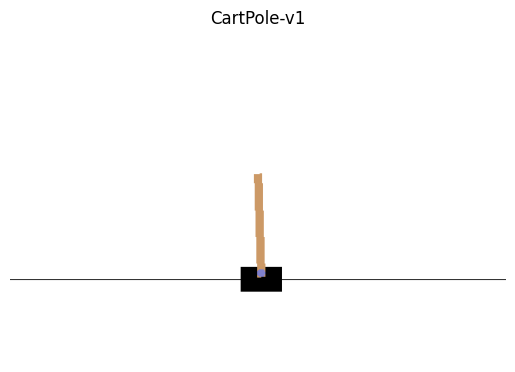

In [6]:
tmp_env = make_env(args.env_id, args.seed, 0, False, None)()
ob = tmp_env.reset()

plt.title(args.env_id)
plt.imshow(tmp_env.render("rgb_array"))
plt.axis('off')
plt.show()

In [7]:
action = tmp_env.action_space.sample()
ob, reward, done, info = tmp_env.step(action)
action, ob

(1, array([ 0.03076804,  0.19700098, -0.03151444, -0.33357874], dtype=float32))

## Modeling

### Define Neural Network

In [8]:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x)

### DQN training Wrapper

In [9]:
from torch_rl.dqn import (
    DQN,
    DQNTrainingWrapper
)


dqn = DQN(
    model_func=lambda: QNetwork(envs),
    device=device
)

wrapper = DQNTrainingWrapper(
    model = dqn,
    env=envs,
    device=device
)

optimizer = wrapper.get_optimizer(lr=args.learning_rate)

rb = wrapper.get_replay_buffer(
    buffer_size=args.buffer_size,
    optimize_memory_usage=True
)

### Setup plots

In [10]:
from torch_rl.utils import SPS
def log_env_metrics(ms, step, infos):
    for info in infos:
        if "episode" in info.keys():
            ms.log_metric("episodic_return", info["episode"]["r"], step=step)
            ms.log_metric("episodic_length", info["episode"]["l"], step=step)


def plot_metric(global_step, ms, sps):
    metric_list = ["episodic_return", "episodic_length", "q_values", "loss"]
    color_list = ["blue", "black", "green", "red"]
    sps.step(global_step)
    plot_metrics_notebook(ms, metric_list, color_list, sps=sps)

### DQN training loop

100% processed at 2089 SPS. Remaining: 00 second(s) 



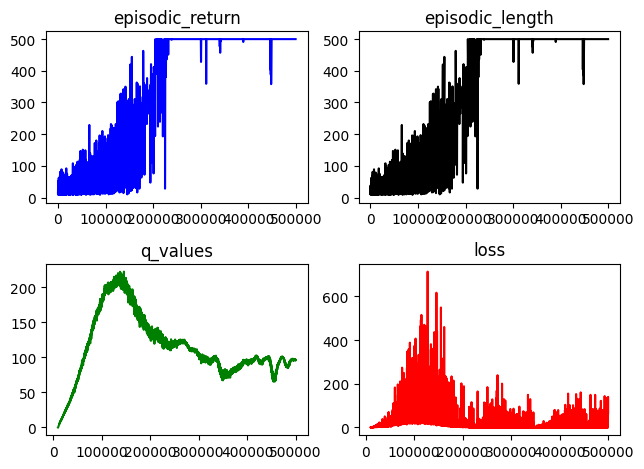

In [11]:
ms = MetricStore()
sps = SPS(args.total_timesteps)
obs = envs.reset()
for global_step in range(args.total_timesteps):
    epsilon = wrapper.linear_schedule(
        args.start_e,
        args.end_e,
        args.exploration_fraction * args.total_timesteps,
        global_step
    )

    if random.random() < epsilon:
        actions = np.array([envs.single_action_space.sample()
                            for _ in range(envs.num_envs)])
    else:
        actions = dqn(torch.Tensor(obs).to(device)).cpu().numpy()

    next_obs, rewards, dones, infos = envs.step(actions)

    next_real_obs = handle_terminal_ob(next_obs, dones, infos)
    rb.add(obs, next_real_obs, actions, rewards, dones)
    obs = next_obs

    log_env_metrics(ms, global_step, infos)

    if global_step > args.learning_starts and global_step % args.train_frequency == 0:
        data = rb.sample(args.batch_size)
        q_values, loss = wrapper.train_step(data, gamma=args.gamma)

        if global_step % 100 == 0:
            ms.log_metric("q_values", q_values.mean().item(), step=global_step)
            ms.log_metric("loss", loss, step=global_step)

        if global_step % 10000 == 0:
            plot_metric(global_step, ms, sps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if global_step % args.target_network_frequency == 0:
            dqn.update_target_network()

plot_metric(global_step, ms, sps)
envs.close()

## Evaluation

In [12]:
run_test_name = f"test-{run_name}"
test_env = make_env(args.env_id, args.seed, 0, True, run_test_name)()

ob = test_env.reset()
while True:
    action = dqn(torch.Tensor(np.array([ob])).to(device)).cpu().numpy()[0]
    ob, reward, done, info = test_env.step(action)
    if done:
        print(f'episodic_return={info["episode"]["r"]}, episodic_length={info["episode"]["l"]}')
        break


episodic_return=500.0, episodic_length=500


### Display full evaluation

In [13]:
mp4_path = f"videos/{run_test_name}/rl-video-episode-0.mp4"
gif_path = f"images/dqn_test.gif"

mp4_to_gif(mp4_path, gif_path)
Image(url=gif_path, width=500, height=500)

Writing frame 500
Finalizing...
Done.
